<a href="https://colab.research.google.com/github/AndresChavez123/Sys2025-2/blob/main/Parcial2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descargando audio desde YouTube...


Audio descargado: audio_youtube.wav

🔊 Reproduciendo mensaje original...



🔊 Reproduciendo señal modulada (DSB-CS)...



🔊 Reproduciendo salida del mezclador...



🔊 Reproduciendo señal filtrada LPF...



🔊 Reproduciendo señal recuperada final...


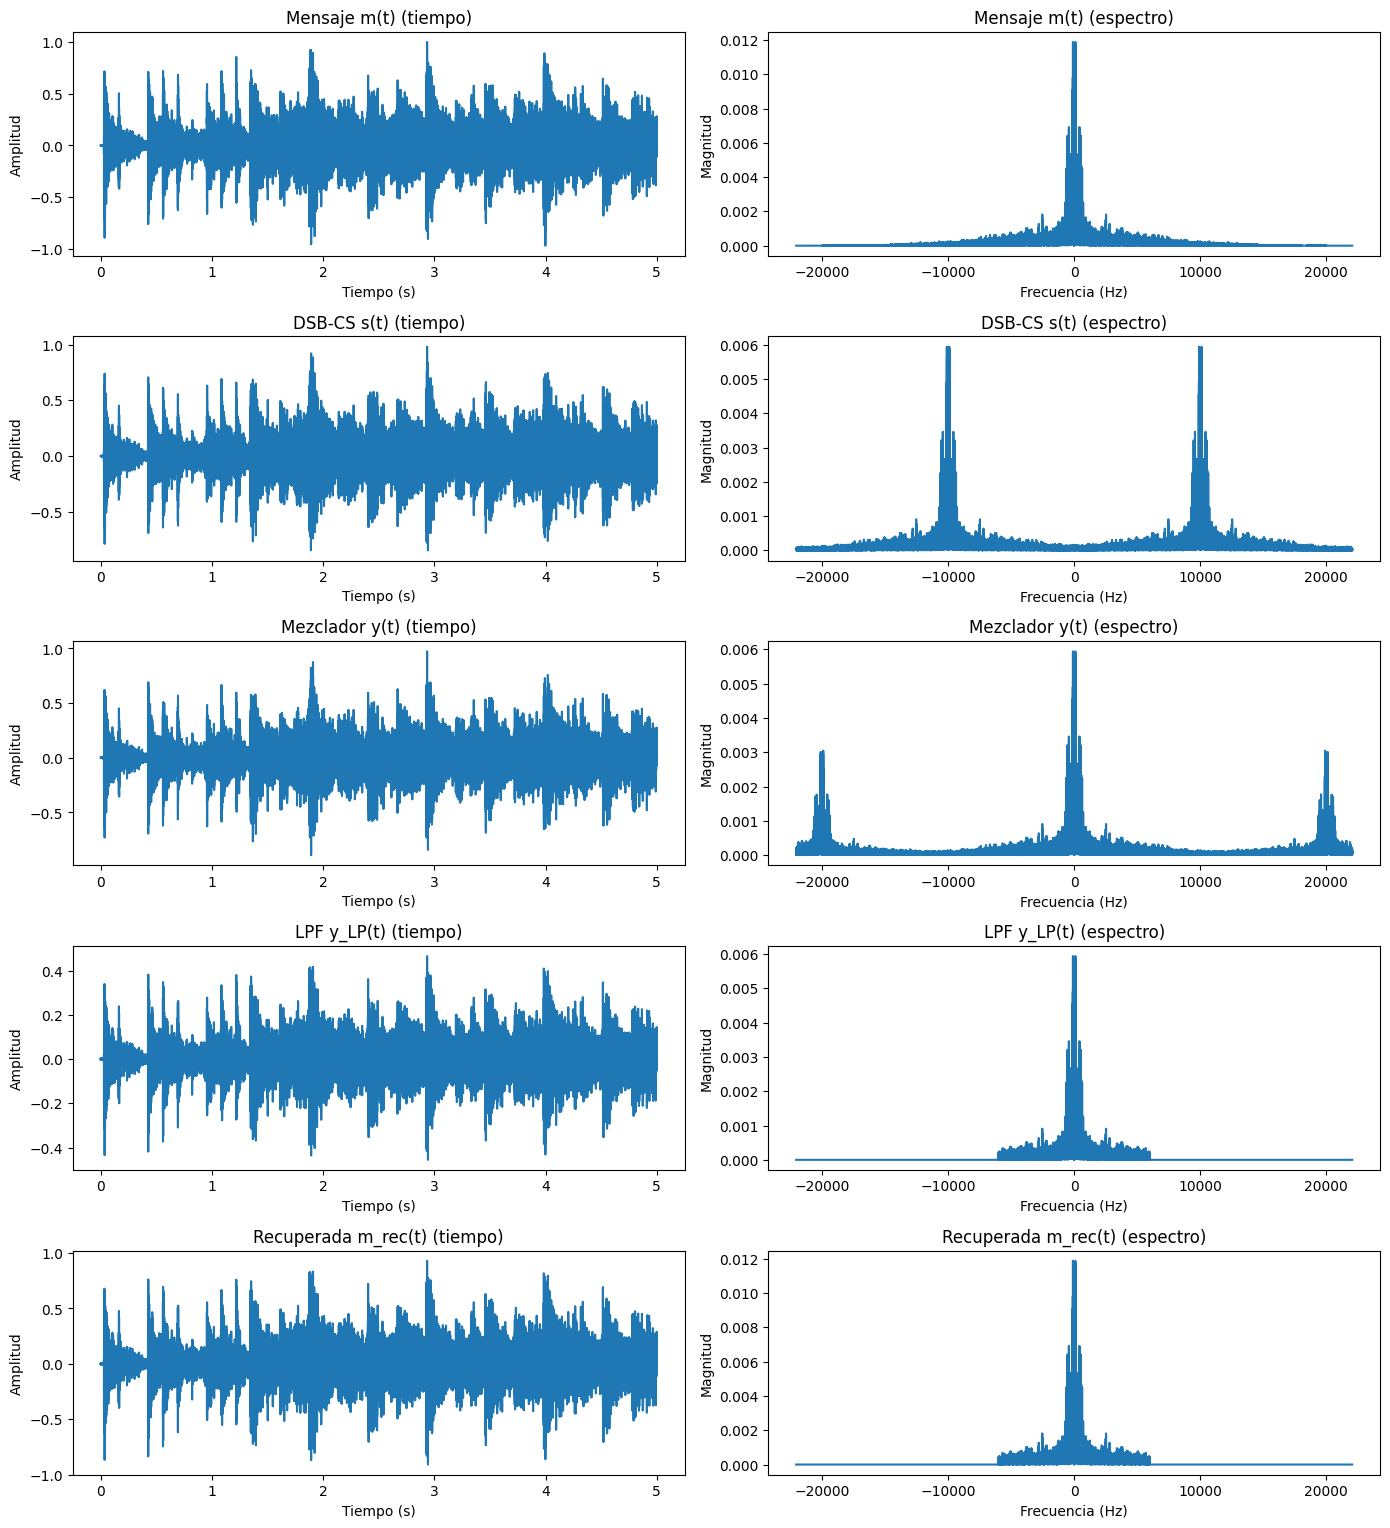


Archivo guardado: recovered_youtube.wav


In [ ]:
# demodulador_am_fft_youtube_audio.py

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.signal import resample
from IPython.display import Audio
import yt_dlp
import os

# -------------------------
# PARÁMETROS
# -------------------------
YOUTUBE_LINK = "https://www.youtube.com/watch?v=dQw4w9WgXcQ"  # REEMPLAZA AQUÍ TU LINK
A1 = 1.0
f0 = 10000.0
fs_target = 44100
LP_cutoff = 6000.0
duration = 5.0
# -------------------------

# -------------------------
# 1. DESCARGAR AUDIO DESDE YOUTUBE
# -------------------------

output_file = "audio_youtube.wav"

ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': 'audio_temp.%(ext)s',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
    'quiet': True
}

print("Descargando audio desde YouTube...")
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([YOUTUBE_LINK])

# Identificar wav generado
for fname in os.listdir("."):
    if fname.startswith("audio_temp") and fname.endswith(".wav"):
        os.rename(fname, output_file)
        break

print("Audio descargado:", output_file)

# -------------------------
# 2. CARGAR EL AUDIO Y PREPARAR EL MENSAJE m(t)
# -------------------------

x, fs = sf.read(output_file)

if x.ndim > 1:
    x = x.mean(axis=1)

# Re-muestreo si no coincide
if fs != fs_target:
    N_target = int(len(x) * fs_target / fs)
    x = resample(x, N_target)
    fs = fs_target

# Recortar o extender
N_needed = int(duration * fs)
if len(x) > N_needed:
    x = x[:N_needed]
elif len(x) < N_needed:
    x = np.pad(x, (0, N_needed - len(x)))

# Normalizar
m = x / np.max(np.abs(x))
t = np.arange(len(m)) / fs

print("\n🔊 Reproduciendo mensaje original...")
display(Audio(m, rate=fs))

# -------------------------
# 3. MODULACIÓN
# -------------------------

carrier = np.cos(2*np.pi*f0*t)
s = A1 * m * carrier

print("\n🔊 Reproduciendo señal modulada (DSB-CS)...")
display(Audio(s, rate=fs))

# -------------------------
# 4. MEZCLADOR
# -------------------------

y = s * carrier

print("\n🔊 Reproduciendo salida del mezclador...")
display(Audio(y, rate=fs))

# -------------------------
# 5. FILTRO PASA-BAJAS POR FFT
# -------------------------

def fft_lpf(signal, fs, cutoff):
    N = len(signal)
    S = fft(signal)
    freqs = fftfreq(N, 1/fs)
    mask = np.abs(freqs) <= cutoff
    S_filtered = S * mask
    x_filtered = np.real(ifft(S_filtered))
    return x_filtered, freqs, S, S_filtered

y_lp, freqs, Y_fft, Yf_fft = fft_lpf(y, fs, LP_cutoff)

print("\n🔊 Reproduciendo señal filtrada LPF...")
display(Audio(y_lp, rate=fs))

# -------------------------
# 6. ESCALADO FINAL
# -------------------------

m_rec = (2.0 / A1) * y_lp

print("\n🔊 Reproduciendo señal recuperada final...")
display(Audio(m_rec, rate=fs))

# -------------------------
# 7. GRAFICADO
# -------------------------

def plot_spectrum(signal, fs, title, ax_time, ax_freq):
    N = len(signal)
    tvec = np.arange(N)/fs
    S = fft(signal)
    f = fftfreq(N, 1/fs)
    S_shift = fftshift(S)
    f_shift = fftshift(f)
    mag = np.abs(S_shift) / N

    ax_time.plot(tvec, signal)
    ax_time.set_title(title + " (tiempo)")
    ax_time.set_xlabel("Tiempo (s)")
    ax_time.set_ylabel("Amplitud")

    ax_freq.plot(f_shift, mag)
    ax_freq.set_title(title + " (espectro)")
    ax_freq.set_xlabel("Frecuencia (Hz)")
    ax_freq.set_ylabel("Magnitud")

plt.figure(figsize=(14, 18))

plot_spectrum(m, fs, "Mensaje m(t)", plt.subplot(6,2,1), plt.subplot(6,2,2))
plot_spectrum(s, fs, "DSB-CS s(t)", plt.subplot(6,2,3), plt.subplot(6,2,4))
plot_spectrum(y, fs, "Mezclador y(t)", plt.subplot(6,2,5), plt.subplot(6,2,6))
plot_spectrum(y_lp, fs, "LPF y_LP(t)", plt.subplot(6,2,7), plt.subplot(6,2,8))
plot_spectrum(m_rec, fs, "Recuperada m_rec(t)", plt.subplot(6,2,9), plt.subplot(6,2,10))

plt.tight_layout()
plt.show()

# Guardar señal recuperada
sf.write("recovered_youtube.wav", m_rec.astype(np.float32), fs)
print("\nArchivo guardado: recovered_youtube.wav")
